In [1]:
from datasets import load_dataset
import pandas as pd
dataset = load_dataset('yelp_review_full')

c:\Users\Kushagra\.conda\envs\mlpy\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
test_dataset = dataset['test']
train_dataset = dataset['train']

In [3]:
df = pd.DataFrame(test_dataset)


In [4]:
df.head()

,label,text
0,0,I got 'new' tires from them and within two wee...
1,0,Don't waste your time. We had two different p...
2,0,All I can say is the worst! We were the only 2...
3,0,I have been to this restaurant twice and was d...
4,0,Food was NOT GOOD at all! My husband & I ate h...


In [5]:
df.describe()

,label
count,50000.000000
mean,2.000000
std,1.414228
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,4.000000


In [6]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [13]:
def batch_tokenize(texts, tokenizer, batch_size=32, max_length=512):
    input_ids = []
    attention_masks = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        tokenized = tokenizer.batch_encode_plus(batch, 
                                                max_length=max_length, 
                                                padding='max_length', 
                                                truncation=True,
                                                return_tensors="tf")
        input_ids.append(tokenized['input_ids'])
        attention_masks.append(tokenized['attention_mask'])

    return input_ids, attention_masks

In [14]:
batch_size = 32  # Adjust this based on your dataset and GPU capacity

# Tokenize in batches with progress bar
tokenized_batches = []
for i in tqdm(range(0, len(df), batch_size), desc='Tokenizing'):
    batch_texts = df['text'][i:i + batch_size].tolist()
    batch_input_ids, batch_attention_masks = batch_tokenize(batch_texts, tokenizer, batch_size)
    tokenized_batches.append((batch_input_ids, batch_attention_masks))

Tokenizing: 100%|██████████| 1563/1563 [03:00<00:00,  8.65it/s]


In [15]:
embeddings = []
for batch_input_ids, batch_attention_masks in tqdm(tokenized_batches, desc='Processing'):
    with tf.device('/GPU:0'):
        for i in range(len(batch_input_ids)):
            outputs = model(batch_input_ids[i], attention_mask=batch_attention_masks[i])
            batch_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
            embeddings.append(batch_embeddings)

Processing: 100%|██████████| 1563/1563 [58:36<00:00,  2.25s/it]  


In [23]:
import numpy as np
all_embeddings = np.vstack(embeddings)

In [287]:
top_embeddings = all_embeddings[:1000]
k = 4 # for example, change it according to your needs
# Perform K-means clustering
kmeans = KMeans(n_clusters=k, random_state=42).fit(top_embeddings)
# Get cluster labels for each point in the dataset
labels = kmeans.labels_


In [292]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=2, random_state=42)
silhouette_score(top_embeddings, kmeans.fit_predict(top_embeddings))

0.08858575

In [280]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.078s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1.960163
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.590542
[t-SNE] KL divergence after 1000 iterations: 1.589042


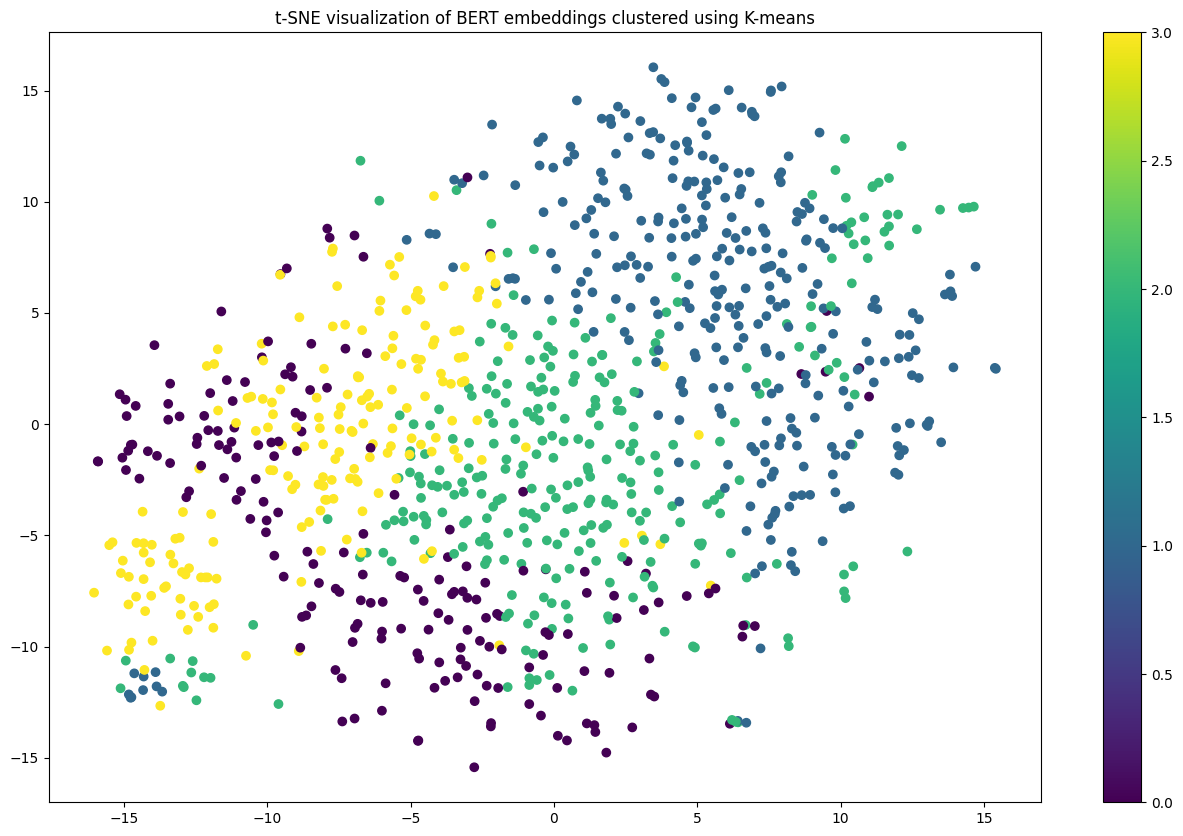

In [281]:

tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000, random_state= 42)
tsne_results = tsne.fit_transform(top_embeddings)

plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results[:,0], tsne_results[:,1], c=kmeans.labels_, cmap='viridis')
plt.title('t-SNE visualization of BERT embeddings clustered using K-means')
plt.colorbar(scatter)
plt.show()

In [283]:
top_df = df.head(1000)  # Create a subset DataFrame with the top 1000 rows
top_df['cluster'] = labels  # Assign cluster labels to this subset

sample_texts = {}
n_samples = 5  # Number of samples per cluster

for cluster_id in range(k):  # Assuming k is the number of clusters
    sample_texts[cluster_id] = top_df[top_df['cluster'] == cluster_id]['text'].sample(n_samples).tolist()

C:\Users\Kushagra\AppData\Local\Temp\ipykernel_9348\4045266529.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_df['cluster'] = labels  # Assign cluster labels to this subset


In [284]:
from openai import OpenAI
import os
client = OpenAI(
  api_key= os.getenv("OPENAI_API_KEY")# this is also the default, it can be omitted
)


In [285]:
for cluster_id in range(k):
    print(f"Cluster {cluster_id} Theme:", end=" ")

    # Creating a prompt for the model with sample texts from each cluster
    reviews_text = "\n".join(sample_texts[cluster_id])
    prompt = f'What do the following customer reviews have in common?\n\nCustomer reviews:\n"""\n{reviews_text}\n"""\n\nTheme:'


    
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages = [
        {
            "role": "user",
            "content": prompt,
        },],
        temperature=0.6,
        max_tokens=64,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0
    )
    

    # Printing the theme
    theme = response.choices[0].message.content
    print(theme)

    for text in sample_texts[cluster_id]:
        print(text[:70])
    print("-" * 100)

Cluster 0 Theme: The common theme among these customer reviews is that they are all discussing different experiences with various establishments.
There are a couple of amazing wood sculptures in the place.  The food 
I moved to Bloomfield in April and being Italian and loving Italian fo
Dr. Curt Thurman is my hero.\n\nI trust Curt with my pets completely. 
I do have a special place in my stomach for Tram's kitchen and I try t
Terrible! \n\nI'm pretty sure I am the apartment above Serena R's revi
----------------------------------------------------------------------------------------------------
Cluster 1 Theme: The common theme among these customer reviews is that they are all discussing their experiences at different food establishments.
fun place to stop for a treat if you're trecking across campus.  perfe
From scratch pastries, breads, breakfast, lunch, dinner options\nCozy 
Grade: D\n\nYeah, I order my martinis served on the rocks and in goble
Our favorite place to go for chocolate